In [368]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn.metrics as metrics
%matplotlib inline

In [369]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [370]:
# Initialize all necessary features
# Initialize SVM
def initialize_svm(C=0.01, gamma=0):
  svm = cv2.ml.SVM_create()
  svm.setGamma(gamma)
  svm.setC(C)
  svm.setKernel(cv2.ml.SVM_LINEAR)
  svm.setType(cv2.ml.SVM_C_SVC)
  svm.setTermCriteria((cv2.TERM_CRITERIA_EPS + 
                         cv2.TERM_CRITERIA_MAX_ITER, 
                         1000, 1e-3))

  return svm


# Train SVM on data and labels
def svm_train(svm, samples, labels):
  svm.train(samples, cv2.ml.ROW_SAMPLE, labels)


# predict labels for given samples
def predict(svm, samples):
  return svm.predict(samples)[1]

# Initialize HOG parameters
window = (64, 128)
block = (16, 16)
block_stride = (8, 8)
cell = (8, 8)
n_bins = 9
derivative_aperature = 1
sigma = -1
norm_type = 0
threshold = 0.2
gamma_correction = True
nlevels = 64
gradient = False

# Initialize HOG
hog = cv2.HOGDescriptor(window, block, block_stride,
                      cell, n_bins,derivative_aperature,
                      sigma, norm_type, threshold, 
                      gamma_correction, nlevels,gradient)

In [371]:
# compute HOG features for given images
def get_hog_features(hog, images):
  hog_features = []
  for image in images:
    hog_feature = hog.compute(image)
    hog_features.append(hog_feature)
  return hog_features

# Convert HOG descriptors to format recognized by SVM
def prepare_for_svm(hog_features):
  featureVectorLength = len(hog_features[0])
  print("Feature vector: ", featureVectorLength)
  data = np.float32(hog_features).reshape(-1, featureVectorLength)
  print("Data: ", data.shape)
  return data

def get_svm_detector_for_hog(model_path, hog):
  svm = cv2.ml.SVM_load(model_path)
  sv = svm.getSupportVectors()
  rho,_ ,_ = svm.getDecisionFunction(0)
  svm_detector = np.zeros(sv.shape[1] + 1, dtype=sv.dtype)
  svm_detector[:-1] = -sv[:]
  svm_detector[-1] = rho
  return svm_detector


In [372]:
# Operating with images
def get_image_paths(folder, extension):
  image_paths = []
  for x in os.listdir(folder):
    x_path = os.path.join(folder, x)
    if os.path.splitext(x_path)[1] in extension:
      image_paths.append(x_path)
  return image_paths


def load_data_and_labels(folder, label):
  images = []
  labels = []
  image_paths = get_image_paths(folder, ['.jpg', '.png', '.jpeg'])
  for image_path in image_paths:
    im = cv2.imread(image_path, cv2.IMREAD_COLOR)
    images.append(im)
    labels.append(label)
  return images, labels

# Path to INRIA Person dataset
root ='../Data/INRIAPerson/'
# set Train and Test directory paths
train = os.path.join(root, 'train_64x128_H96')  # train: 'Data/INRIAPerson/train_64x128_H96'
test = os.path.join(root, 'test_64x128_H96')  # test: 'Data/INRIAPerson/test_64x128_H96'

In [373]:
# Turn on/off training, tFalseg, querying and retraining activities
is_train = False
is_retrain = False

In [374]:
# Traning for the first time
if is_train:
    train_pos = os.path.join(train, 'posPatches')
    train_neg = os.path.join(train, 'negPatches')
    train_pos_images, train_pos_labels = load_data_and_labels(train_pos, 1)
    train_neg_images, train_neg_labels = load_data_and_labels(train_neg, -1)

    train_images = np.concatenate((np.array(train_pos_images), 
                       np.array(train_neg_images)), 
                                  axis=0)
    train_labels = np.concatenate((np.array(train_pos_labels), 
                       np.array(train_neg_labels)),
                                  axis=0)

    hog_train = get_hog_features(hog, train_images)
    train_data = prepare_for_svm(hog_train)

    # Finally create an SVM object, train the model and save it.
    model = initialize_svm(C=0.01, gamma=0)
    svm_train(model, train_data, train_labels)
    model.save('../model/pedestrian.yml')

In [375]:
# Initialize HOG once again
window = (64, 128)
block = (16, 16)
block_stride = (8, 8)
cell = (8, 8)
n_bins = 9
derivative_aperature = 1
sigma = -1
norm_type = 0
threshold = 0.2
gamma_correction = True
nlevels = 64
gradient = False

hog = cv2.HOGDescriptor(window, block, block_stride,
                      cell, n_bins,derivative_aperature,
                      sigma, norm_type, threshold, 
                      gamma_correction, nlevels,gradient)
svm_detector = get_svm_detector_for_hog('../model/pedestrian2.yml', hog)
hog.setSVMDetector(svm_detector)
# Initialize HOG from lib
hog_lib = cv2.HOGDescriptor(window, block, block_stride,
                      cell, n_bins,derivative_aperature,
                      sigma, norm_type, threshold, 
                      gamma_correction, nlevels,gradient)
svm_detector_default = cv2.HOGDescriptor_getDefaultPeopleDetector()
hog_lib.setSVMDetector(svm_detector_default)

In [376]:
def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [377]:
def remove_box_inside(bbox1, bbox2):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    if (y1 <= y2 and x2 + w2 + 1 <= x1 + w1 and y2 + h2 + 1 <= y1 + h1):
        return True
    return False

processing: /home/hoang/Documents/ComputerVision/Project/Data/1.jpg
[[185, 119, 289, 578], [349, 145, 275, 550], [629, 112, 113, 227], [809, 342, 146, 292]]
Trained Detector :: pedestrians detected: 4
Default Detector :: pedestrians detected: 6


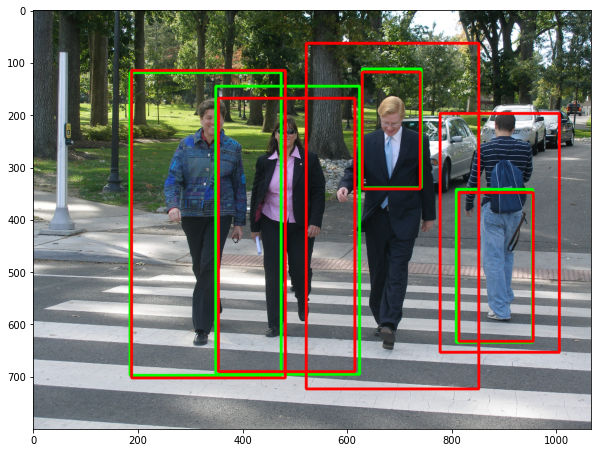

processing: /home/hoang/Documents/ComputerVision/Project/Data/4.jpg
[[233, 249, 267, 534], [413, 311, 243, 487], [625, 192, 305, 608]]
Trained Detector :: pedestrians detected: 3
Default Detector :: pedestrians detected: 3


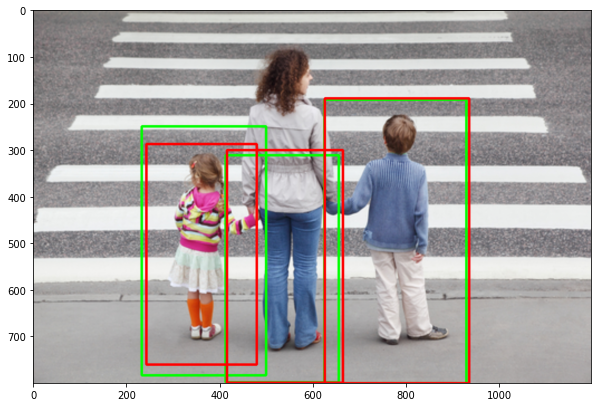

processing: /home/hoang/Documents/ComputerVision/Project/Data/3.jpg
[[0, 132, 251, 557], [191, 303, 134, 267]]
Trained Detector :: pedestrians detected: 2
Default Detector :: pedestrians detected: 2


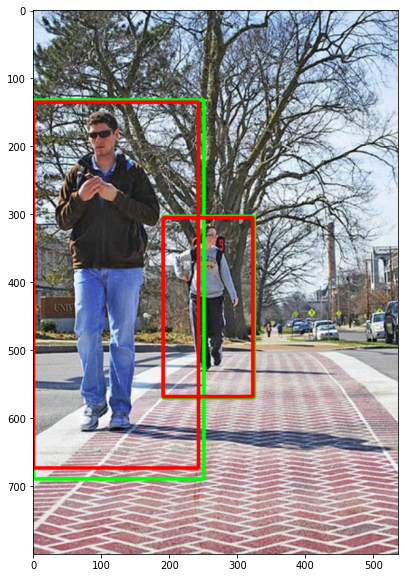

processing: /home/hoang/Documents/ComputerVision/Project/Data/race.jpg
[[26, 178, 141, 281], [201, 167, 157, 313], [297, 0, 77, 141], [352, 149, 178, 356], [529, 172, 142, 284], [691, 179, 162, 324], [895, 282, 76, 152], [916, 3, 66, 132]]
Trained Detector :: pedestrians detected: 9
Default Detector :: pedestrians detected: 10


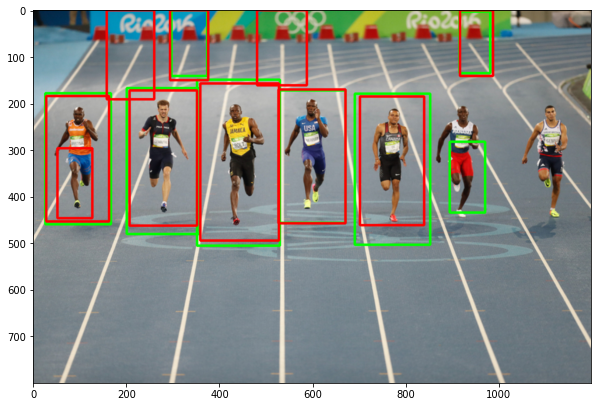

processing: /home/hoang/Documents/ComputerVision/Project/Data/2.jpeg
[[0, 97, 54, 176], [206, 0, 384, 750], [294, 281, 240, 479], [365, 11, 276, 553], [458, 292, 174, 347]]
Trained Detector :: pedestrians detected: 5
Default Detector :: pedestrians detected: 4


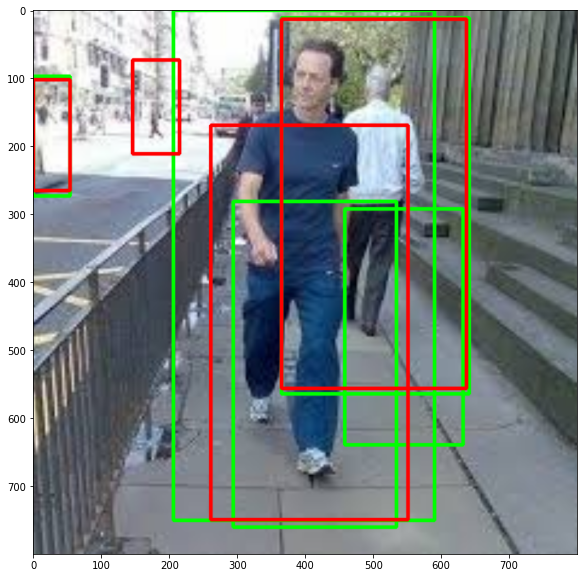

processing: /home/hoang/Documents/ComputerVision/Project/Data/5.jpg
[[0, 594, 48, 184], [215, 349, 208, 416], [382, 148, 333, 652], [758, 471, 67, 135], [811, 520, 105, 211]]
Trained Detector :: pedestrians detected: 5
Default Detector :: pedestrians detected: 4


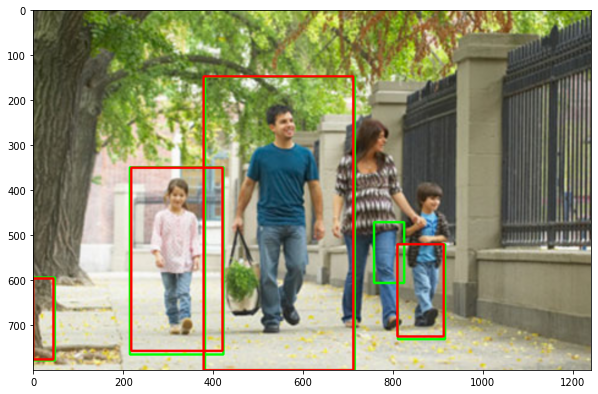

processing: /home/hoang/Documents/ComputerVision/Project/Data/The-Walking-Dead.jpg
[[0, 125, 162, 605], [42, 131, 304, 607], [389, 114, 309, 618], [561, 208, 246, 491], [768, 475, 93, 185], [846, 180, 267, 534], [972, 131, 301, 602], [1134, 192, 269, 538], [1262, 155, 294, 588], [1371, 103, 229, 661], [1558, 234, 42, 164]]
Trained Detector :: pedestrians detected: 13
Default Detector :: pedestrians detected: 11


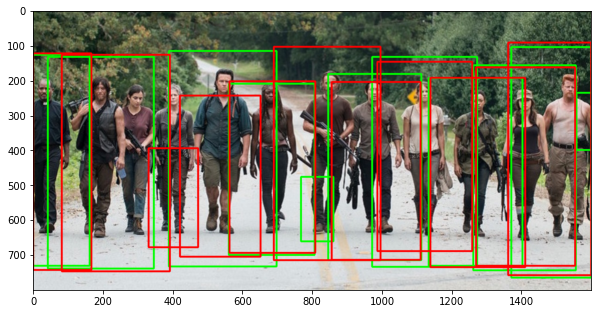

processing: /home/hoang/Documents/ComputerVision/Project/Data/walking_dead_2.jpg
[[65, 101, 333, 665], [335, 159, 321, 641], [738, 71, 364, 728], [1008, 127, 367, 673]]
Trained Detector :: pedestrians detected: 4
Default Detector :: pedestrians detected: 4


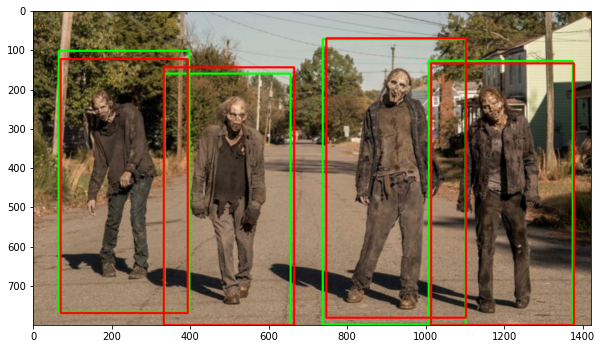

processing: /home/hoang/Documents/ComputerVision/Project/Data/1.jpeg
[[244, 164, 218, 436]]
Trained Detector :: pedestrians detected: 1
Default Detector :: pedestrians detected: 1


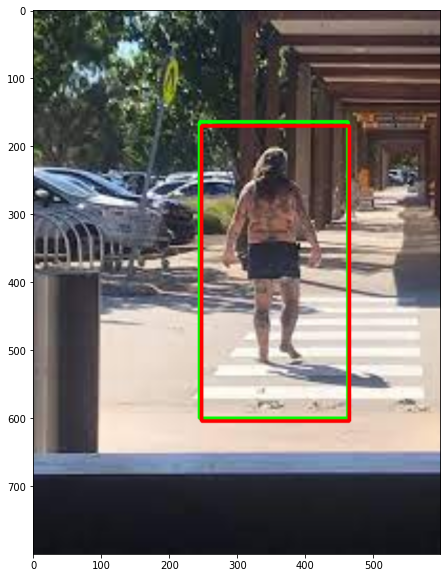

processing: /home/hoang/Documents/ComputerVision/Project/Data/1.png
[[154, 320, 173, 347], [313, 500, 66, 131], [832, 475, 77, 153], [1019, 555, 135, 245], [1187, 620, 66, 131]]
Trained Detector :: pedestrians detected: 5
Default Detector :: pedestrians detected: 3


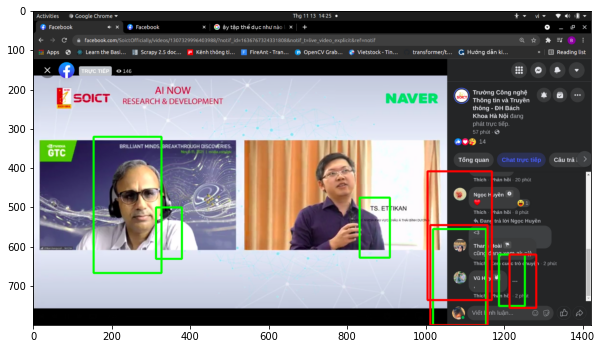

In [390]:
imageDir = 'Data'
# image_paths = glob.glob(os.path.join(imageDir, '*.jpg'))
image_paths = get_image_paths('/home/hoang/Documents/ComputerVision/Project/Data', ['.jpg', '.png', '.jpeg'])
# image_paths = get_image_paths('/home/hoang/Pictures', ['.jpg', '.png', '.jpeg'])
finalHeight = 800

for imagePath in image_paths:
    print('processing: {}'.format(imagePath))
    im = cv2.imread(imagePath, cv2.IMREAD_COLOR)
    scale = finalHeight / im.shape[0]
    im = cv2.resize(im, None, fx=scale, fy=scale)
    
    bboxes, weights = hog.detectMultiScale(im, winStride=(4, 4),
                                    padding=(32, 32),scale=1.05, 
                                    finalThreshold=2,hitThreshold=1.0)

    bboxes2, weights2 = hog_lib.detectMultiScale(im, winStride=(8, 8), 
                                padding=(32, 32),scale=1.05, 
                                finalThreshold=2,hitThreshold=0)

    bbox_final = non_max_suppression_fast(bboxes, 0.9).tolist()
    bbox_final.sort(key=lambda x: x[0])
    sub_bbox = [] 
    shape_bb = len(bbox_final)
    for i in range(shape_bb): 
        for j in range(i + 1, shape_bb):
            if (remove_box_inside(bbox_final[i], bbox_final[j])):
                sub_bbox.append(bbox_final[j])
    for i in range(len(sub_bbox)):
        bbox_final.remove(sub_bbox[i])
    # print(bbox_final)
    if len(bboxes) > 0:
        print('Trained Detector :: pedestrians detected: {}'
                .format(bboxes.shape[0]))
    if len(bboxes2) > 0:
        print('Default Detector :: pedestrians detected: {}'
                .format(bboxes2.shape[0]))
    
    for bbox in bbox_final:
        x1, y1, w, h = bbox
        x2, y2 = x1 + w, y1 + h
        cv2.rectangle(im, (x1, y1), (x2, y2), 
                      (0, 255, 0), thickness=3, 
                      lineType=cv2.LINE_AA)

    for bbox in bboxes2:
        x1, y1, w, h = bbox
        x2, y2 = x1 + w, y1 + h
        cv2.rectangle(im, (x1, y1), (x2, y2), 
                      (0, 0, 255), thickness=3, 
                      lineType=cv2.LINE_AA)
                      
    plt.imshow(im[:,:,::-1])
    # Write image to disk
    # imResultPath = os.path.join('results', os.path.basename(imagePath))
    # cv2.imwrite(imResultPath, im)
    plt.show()

In [379]:
def getHardExamples(negImageList, hog_descriptor):
    hardNegList = []
    hog_descriptor.setSVMDetector(get_svm_detector_for_hog('../model/pedestrian.yml', hog_descriptor))

    for i in range(len(negImageList)):
        bboxes_hard, _ = hog.detectMultiScale(negImageList[i], winStride=(8, 8),
                                    padding=(32, 32),scale=1.05, 
                                    finalThreshold=2,hitThreshold=1.0)
        for (x,y,w,h) in bboxes_hard:
            hardExample = negImageList[i][y:y+h, x:x+w]
            hardNegList.append(cv2.resize(hardExample,(64,128)))

    return hardNegList

In [380]:
window = (64, 128)
block = (16, 16)
block_stride = (8, 8)
cell = (8, 8)
n_bins = 9
derivative_aperature = 1
sigma = -1
norm_type = 0
threshold = 0.2
gamma_correction = True
nlevels = 64
gradient = False

hog_retrain = cv2.HOGDescriptor(window, block, block_stride,
                        cell, n_bins, derivative_aperature,
                        sigma, norm_type, threshold,
                        gamma_correction, nlevels, gradient)

In [381]:
train = os.path.join(root, 'train_64x128_H96')
train_pos = os.path.join(train, 'posPatches')
train_neg = os.path.join(train, 'negPatches')
train_pos_images, train_pos_labels = load_data_and_labels(train_pos, 1)
train_neg_images, train_neg_labels = load_data_and_labels(train_neg, -1)
train_images = np.concatenate((np.array(train_pos_images), 
                    np.array(train_neg_images)), 
                                axis=0)
train_labels = np.concatenate((np.array(train_pos_labels), 
                    np.array(train_neg_labels)),
                                axis=0)

FileNotFoundError: [Errno 2] No such file or directory: '../Data/INRIAPerson/train_64x128_H96/posPatches'

In [ ]:
if is_retrain:
    print("Start loading images from other source")
    negImages = []
    for i in os.listdir('../Data/13_Natural_Scene'):
        images, train_neg_labels = load_data_and_labels(os.path.join('../Data/13_Natural_Scene', i), -1)
        for image in images:
            negImages.append(image)
    # images, train_neg_labels = load_data_and_labels('INRIAPerson/train_64x128_H96/negPatches', -1)
    for image in images:
        negImages.append(image)
    print("Finish loading, get hard negative images")                      
    hardNegListImages = getHardExamples(negImages, hog_retrain)
    hardNegLabels = [-1 for i in range(len(hardNegListImages))]
    retrain_images = np.concatenate((np.array(train_images), 
                    np.array(hardNegListImages)), 
                                axis=0)
    retrain_labels = np.concatenate((np.array(train_labels), 
                        np.array(hardNegLabels)),
                                    axis=0)
    hog_retrain_features = get_hog_features(hog_retrain, retrain_images)
    retrain_data = prepare_for_svm(hog_retrain_features)
    model = initialize_svm(C=0.01, gamma=0)
    print("Retraining the model")
    svm_train(model, retrain_data, retrain_labels)
    model.save('../model/pedestrian2.yml')

Start loading images from other source
Finish loading, get hard negative images
Feature vector:  3780
Data:  (14765, 3780)
Retraining the model


In [ ]:
svm_detector = get_svm_detector_for_hog('../model/pedestrian2.yml', hog)
hog.setSVMDetector(svm_detector)

processing: /home/hoang/Documents/ComputerVision/Project/Data/1.jpg
Trained Detector :: pedestrians detected: 3
Default Detector :: pedestrians detected: 6


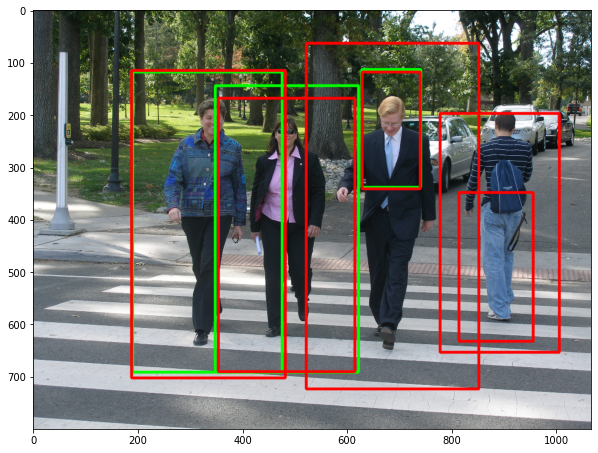

processing: /home/hoang/Documents/ComputerVision/Project/Data/4.jpg
Trained Detector :: pedestrians detected: 3
Default Detector :: pedestrians detected: 3


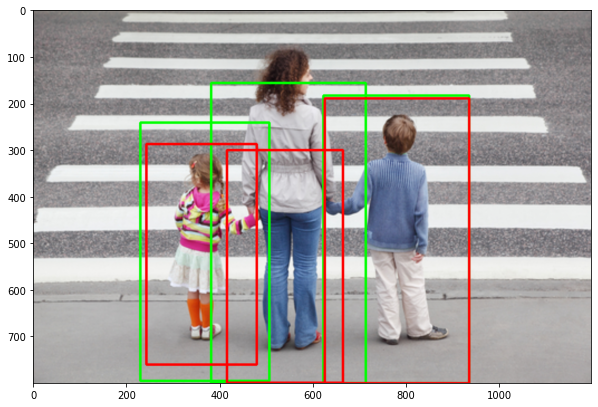

processing: /home/hoang/Documents/ComputerVision/Project/Data/3.jpg
Trained Detector :: pedestrians detected: 2
Default Detector :: pedestrians detected: 2


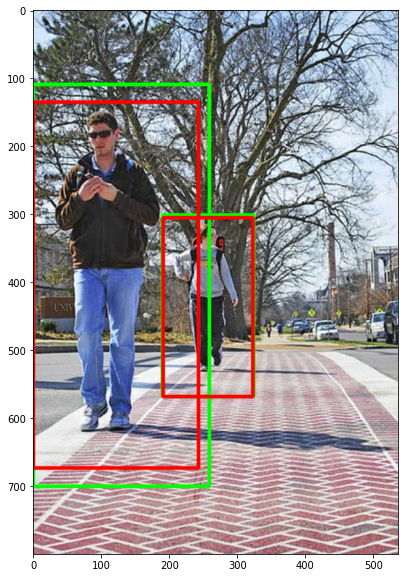

processing: /home/hoang/Documents/ComputerVision/Project/Data/race.jpg
Trained Detector :: pedestrians detected: 7
Default Detector :: pedestrians detected: 10


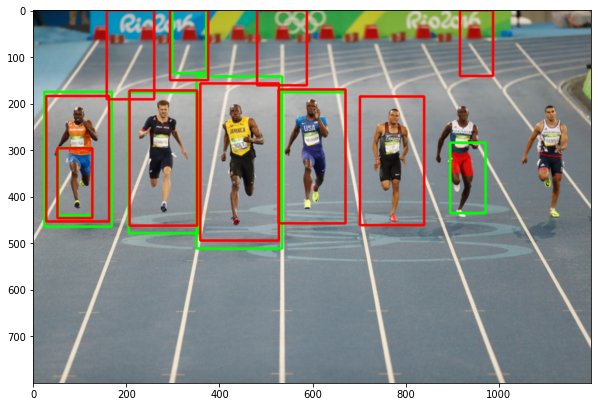

processing: /home/hoang/Documents/ComputerVision/Project/Data/2.jpeg
Trained Detector :: pedestrians detected: 3
Default Detector :: pedestrians detected: 4


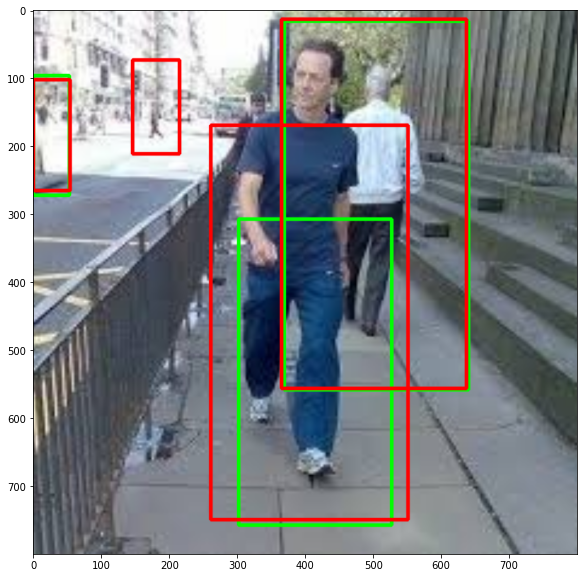

processing: /home/hoang/Documents/ComputerVision/Project/Data/5.jpg
Trained Detector :: pedestrians detected: 3
Default Detector :: pedestrians detected: 4


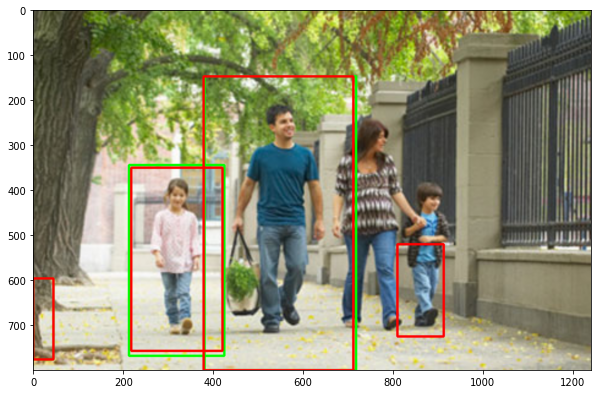

processing: /home/hoang/Documents/ComputerVision/Project/Data/The-Walking-Dead.jpg
Trained Detector :: pedestrians detected: 8
Default Detector :: pedestrians detected: 11


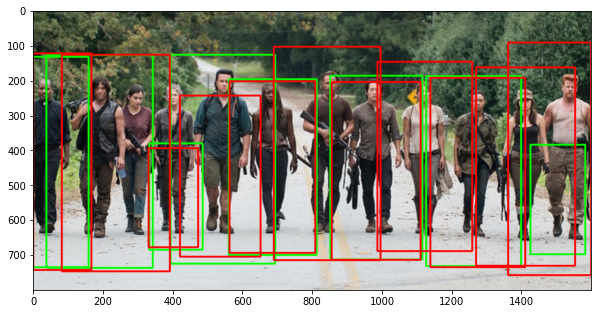

processing: /home/hoang/Documents/ComputerVision/Project/Data/walking_dead_2.jpg
Trained Detector :: pedestrians detected: 5
Default Detector :: pedestrians detected: 4


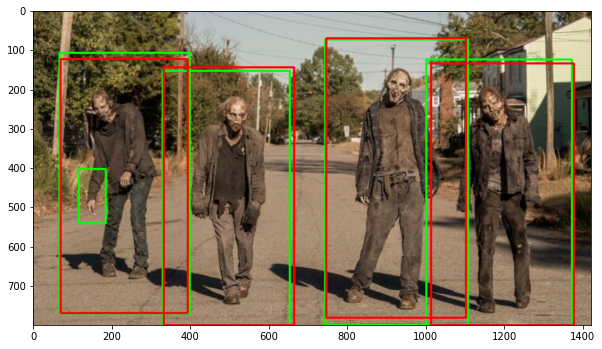

processing: /home/hoang/Documents/ComputerVision/Project/Data/1.jpeg
Trained Detector :: pedestrians detected: 1
Default Detector :: pedestrians detected: 1


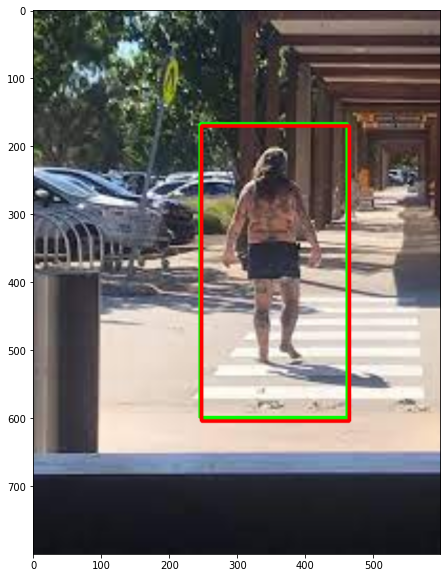

processing: /home/hoang/Documents/ComputerVision/Project/Data/1.png
Trained Detector :: pedestrians detected: 1
Default Detector :: pedestrians detected: 3


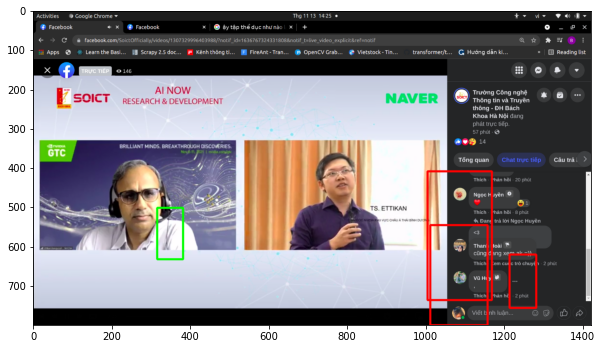

In [ ]:
# read images from pedestrians directory
imageDir = 'Data'
image_paths = get_image_paths('/home/hoang/Documents/ComputerVision/Project/Data', ['.jpg', '.png', '.jpeg'])
finalHeight = 800.0

for imagePath in image_paths:
    print('processing: {}'.format(imagePath))
    im = cv2.imread(imagePath, cv2.IMREAD_COLOR)
    scale = finalHeight / im.shape[0]
    im = cv2.resize(im, None, fx=scale, fy=scale)
    
    bboxes, weights = hog.detectMultiScale(im, winStride=(8, 8),
                                    padding=(32, 32),scale=1.05, 
                                    finalThreshold=2,hitThreshold=1.0)

    # detectMultiScale using default detector
    bboxes2, weights2 = hog_lib.detectMultiScale(im, winStride=(8, 8), 
                                padding=(32, 32),scale=1.05, 
                                finalThreshold=2,hitThreshold=0)
    
    if len(bboxes) > 0:
        print('Trained Detector :: pedestrians detected: {}'
                .format(bboxes.shape[0]))
    if len(bboxes2) > 0:
        print('Default Detector :: pedestrians detected: {}'
                .format(bboxes2.shape[0]))

    for bbox in bboxes:
        x1, y1, w, h = bbox
        x2, y2 = x1 + w, y1 + h
        cv2.rectangle(im, (x1, y1), (x2, y2), 
                      (0, 255, 0), thickness=3, 
                      lineType=cv2.LINE_AA)

    for bbox in bboxes2:
        x1, y1, w, h = bbox
        x2, y2 = x1 + w, y1 + h
        cv2.rectangle(im, (x1, y1), (x2, y2), 
                      (0, 0, 255), thickness=3, 
                      lineType=cv2.LINE_AA)

    plt.imshow(im[:,:,::-1])
    # Write image to disk
    # imResultPath = os.path.join('results', os.path.basename(imagePath))
    # cv2.imwrite(imResultPath, im)
    plt.show()